# Proyecto 04 

### Series de Tiempo

### Dataset: Flujo Vehicular por Unidades de Peaje AUSA

**Descargar el dataset [aquí](https://data.buenosaires.gob.ar/dataset/flujo-vehicular-por-unidades-peaje-ausa). -  años 2017, 2018 y 2019.**


**Importante:** Para la predicción, debes comenzar con los datos de la autopista Illia, pago en Efectivo.

### Exploración de datos

Dedícale un buen tiempo a hacer un Análisis Exploratorio de Datos. Elige preguntas que creas que puedas responder con este dataset. Por ejemplo, ¿Cuáles son los días y horarios de mayor tráfico? También, estudia autocorrelaciones, resampleos, etc.

#### Componentes de la serie (Con Prophet)

1. Calcula las componentes estacionales y tendencia de la serie. Interpreta los resultados, si es necesario con información auxiliar (por fuera del dataset) o elementos del dataset que no estés utilizando (por ejemplo, si la tendencia es negativa, ¿puede ser porque se migre a otras formas de pago?).
1. ¿La serie posee valores atípicos? Si es así, interpreta, si es necesario con información auxiliar. **Pista**: primer semestre 2019.

### Predicción a Futuro (Con Prophet y con Redes Neuronales Recurrentes)

Debes implementar un modelo que prediga el tráfico en la autopista Illia para el último trimestre del 2019. 

1. Haz todas las transformaciones de datos que consideres necesarias. Justifica.
1. Evalúa de forma apropiada tus resultados. Justifica la métrica elegida.
1. Elige un modelo benchmark y compara tus resultados con este modelo.



### 1. Preparación del Dataset

Yo utilice este articulo para entender el funcionamiento de Prophet [Prophet Article](https://towardsdatascience.com/time-series-analysis-with-facebook-prophet-how-it-works-and-how-to-use-it-f15ecf2c0e3a)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib.dates import MonthLocator, num2date
from matplotlib.ticker import FuncFormatter

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#data_2020 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Proyecto 04/flujo-vehicular-2020.csv', sep =',')
data_2019 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Proyecto 04/flujo-vehicular-2019.csv', sep =',')
data_2018 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Proyecto 04/flujo-vehicular-2018.csv', sep =',')
data_2017 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Proyecto 04/flujo-vehicular-2017.csv', sep =',')

Investiguemos que valores toman los campos **estacion, sentido, tipo_vehiculo y forma_pago**

In [ ]:
print(data_2019['estacion'].unique())
print(data_2018['estacion'].unique())
print(data_2017['estacion'].unique())

['Alberti' 'Avellaneda' 'Dellepiane' 'Illia' 'Retiro' 'Salguero'
 'Sarmiento' 'PDB']
['Alberdi' 'Avellaneda' 'Dellepiane Centro' 'Dellepiane Liniers' 'Illia'
 'Retiro' 'Salguero' 'Sarmiento']
['Alberdi' 'Avellaneda' 'Dellepiane Centro' 'Dellepiane Liniers' 'Illia'
 'Retiro' 'Salguero' 'Sarmiento']


In [ ]:
print(data_2019['sentido'].unique())
print(data_2018['sentido'].unique())
print(data_2017['sentido'].unique())

['Centro' 'Provincia']
['Centro' 'Provincia']
['Centro' 'Provincia']


In [ ]:
print(data_2019['tipo_vehiculo'].unique())
print(data_2018['tipo_vehiculo'].unique())
print(data_2017['tipo_vehiculo'].unique())

['Liviano' 'Pesado']
['Liviano' 'Pesado']
['Liviano' 'Pesado']


In [ ]:
print(data_2019['forma_pago'].unique())
print(data_2018['forma_pago'].unique())
print(data_2017['forma_pago'].unique())

['NO COBRADO' 'TELEPASE' 'EFECTIVO' 'EXENTO' 'INFRACCION'
 'T. DISCAPACIDAD']
['NO COBRADO' 'TELEPASE' 'EFECTIVO' 'EXENTO' 'TARJETA DISCAPACIDAD'
 'INFRACCION']
['NO COBRADO' 'TELEPASE' 'EFECTIVO' 'TARJETA DISCAPACIDAD' 'EXENTO'
 'INFRACCION' 'MONEDERO' 'Otros']


##### Podemos decir entonces que los años 2017, 2018 y 2019 tienen las siguientes columnas con la siguiente información:

**periodo**: año del dset 

**fecha**: año dia mes

**hora_inicio** hora de inicio de la cuenta de vehiculos (DROP)

**hora_fin** hora de fin de la cuenta de vehiculos (Vamos a usar esta para tomar la hora)

**dia**: dia de la semana 

**estacion**: estaciones de peaje, difieren levemente entre los años (Dellepiane se unifica en 2019, antes habia Dellepiane Liniers y Centro, y se agrega PDB)

**sentido**: Centro o Provincia

**tipo_vehiculo**: Liviano o Pesado

**forma_pago**: Hay varias y varian entre los años.

**cantidad_pasos**: Cantidad de vehiculos

In [ ]:
#Unimos los 3 datasets, podemos hacerlo asi directamente ya que tienen las mismas columnas
df=pd.concat([data_2019, data_2018, data_2017])

#Pasamos la columna fecha a formato datetime, y le unimos la hora_fin como hora
df['fecha2'] = pd.to_datetime(df.fecha) + pd.to_timedelta(df.hora_fin, unit = 'h')

#Quitamos las columnas fecha y hora_fin ya que las incluimos en el campo fecha2
df.drop(columns=['fecha','hora_fin'], inplace = True)

#Corregimos el nombre de fecha2 a fecha
df.rename(columns = {'fecha2':'fecha'}, inplace = True) 
df.head()

periodo  hora_inicio     dia  ...  forma_pago cantidad_pasos               fecha
0     2019            0  Martes  ...  NO COBRADO             22 2019-01-01 01:00:00
1     2019            0  Martes  ...    TELEPASE              6 2019-01-01 01:00:00
2     2019            0  Martes  ...  NO COBRADO             53 2019-01-01 01:00:00
3     2019            0  Martes  ...    TELEPASE             18 2019-01-01 01:00:00
4     2019            0  Martes  ...    EFECTIVO             16 2019-01-01 01:00:00

[5 rows x 9 columns]

Vemos cual estacion es la que mas pasos  tiene

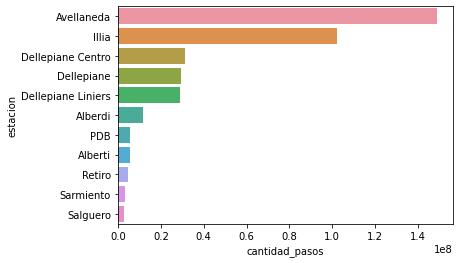

In [ ]:

sns.barplot(y=df.groupby(["estacion"]).cantidad_pasos.sum().sort_values(ascending=False).index,x=df.groupby(["estacion"]).cantidad_pasos.sum().sort_values(ascending=False))
plt.show()

Vamos a estar trabajando con la estación **Illia** y la forma de pago **Efectivo**


In [ ]:
#Unimos los 3 datasets, podemos hacerlo asi directamente ya que tienen las mismas columnas
dataset = pd.concat([data_2019, data_2018, data_2017])

#Nos quedamos solamente con la estación Illia y la forma de pago Efectivo
mask = np.logical_and(dataset.estacion=='Illia', dataset.forma_pago == 'EFECTIVO')
dataset = dataset[mask]

#Quitamos las columnas que no vamos a utilizar
dataset.drop(columns = ['periodo','hora_inicio','forma_pago', 'estacion'], inplace = True)

dataset.head()

fecha  hora_fin     dia    sentido tipo_vehiculo  cantidad_pasos
80   2019-01-01         2  Martes     Centro       Liviano             537
86   2019-01-01         2  Martes     Centro        Pesado               1
88   2019-01-01         2  Martes  Provincia       Liviano             443
94   2019-01-01         2  Martes  Provincia        Pesado               1
149  2019-01-01         3  Martes     Centro       Liviano             769

In [ ]:
#Pasamos la columna fecha a formato datetime, y le unimos la hora_fin como hora
dataset['fecha2'] = pd.to_datetime(dataset.fecha) + pd.to_timedelta(dataset.hora_fin, unit = 'h')

#Quitamos las columnas fecha y hora_fin ya que las incluimos en el campo fecha2
dataset.drop(columns=['fecha','hora_fin'], inplace = True)

#Corregimos el nombre de fecha2 a fecha
dataset.rename(columns = {'fecha2':'fecha'}, inplace = True) 
dataset.head()
dataset.head()

dia    sentido tipo_vehiculo  cantidad_pasos               fecha
80   Martes     Centro       Liviano             537 2019-01-01 02:00:00
86   Martes     Centro        Pesado               1 2019-01-01 02:00:00
88   Martes  Provincia       Liviano             443 2019-01-01 02:00:00
94   Martes  Provincia        Pesado               1 2019-01-01 02:00:00
149  Martes     Centro       Liviano             769 2019-01-01 03:00:00

In [ ]:
#Reordenamos el dataset por fecha
dataset.sort_values('fecha', inplace = True)
dataset.reset_index(drop=True, inplace = True)
dataset

dia    sentido tipo_vehiculo  cantidad_pasos               fecha
0       Domingo  Provincia        Pesado               1 2017-01-01 00:00:00
1       Domingo  Provincia       Liviano               9 2017-01-01 00:00:00
2       Domingo  Provincia       Liviano             644 2017-01-01 00:00:00
3       Domingo  Provincia        Pesado               6 2017-01-01 00:00:00
4       Domingo  Provincia        Pesado               1 2017-01-01 00:00:00
...         ...        ...           ...             ...                 ...
238864   Martes  Provincia       Liviano             556 2019-12-31 22:00:00
238865   Martes  Provincia        Pesado               1 2019-12-31 22:00:00
238866   Martes     Centro       Liviano             580 2019-12-31 22:00:00
238867   Martes     Centro       Liviano             214 2019-12-31 23:00:00
238868   Martes  Provincia       Liviano             190 2019-12-31 23:00:00

[238869 rows x 5 columns]

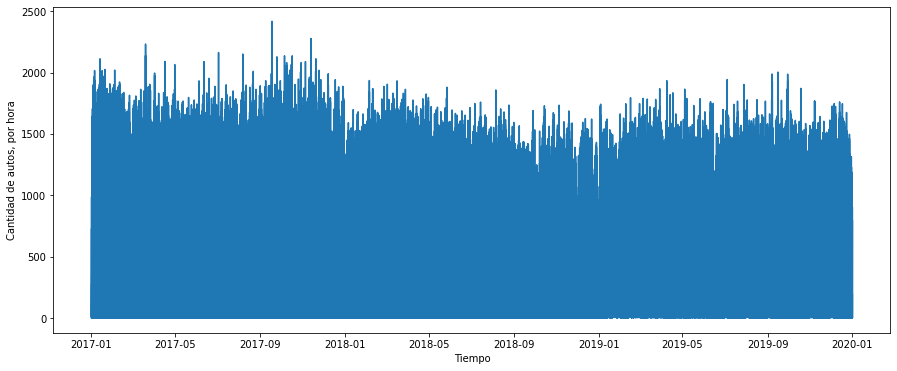

In [ ]:
#Graficamos nuestros datos, tal como están
plt.figure(figsize = (15,6))
plt.plot(dataset.fecha, dataset.cantidad_pasos)
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por hora')
plt.show()

In [ ]:
#Resampleamos nuestros datos para agrupar por dia, y asi tal vez lograr una visualización mas amigable
diario = dataset.resample('D', on = 'fecha').sum()
print(diario.shape)
diario.head()

(1095, 1)


cantidad_pasos
fecha                     
2017-01-01           31183
2017-01-02           51568
2017-01-03           51093
2017-01-04           53332
2017-01-05           56486

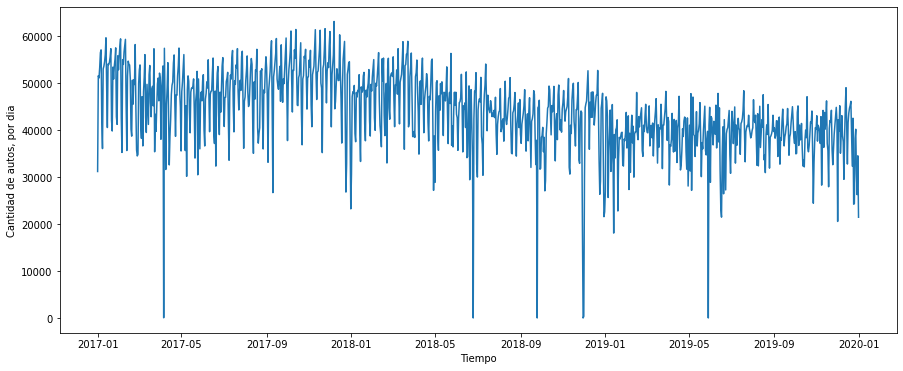

In [ ]:
plt.figure(figsize = (15,6))
plt.plot(diario.index, diario.cantidad_pasos)
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por dia')
plt.show()

In [ ]:
#Resampleamos nuestros datos para agrupar por semana, y asi tal vez lograr una visualización mas amigable
semanal = dataset.resample('W',on = 'fecha').sum()
print(semanal.shape)
semanal.head()

(158, 1)


cantidad_pasos
fecha                     
2017-01-01           31183
2017-01-08          347212
2017-01-15          366413
2017-01-22          357215
2017-01-29          354581

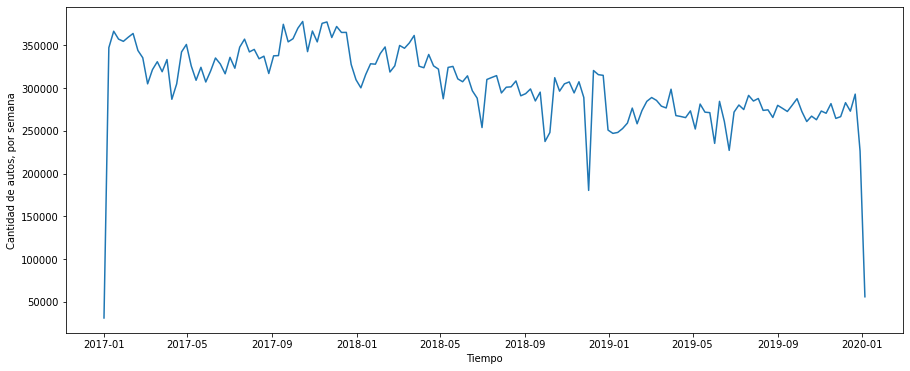

In [ ]:
plt.figure(figsize = (15,6))
plt.plot(semanal.index, semanal.cantidad_pasos)
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por semana')
plt.show()

Instalamos los paquetes necesarios (PROPHET)

In [ ]:
!pip install pystan

!pip install fbprophet

Utilizamos Prophet

### Analisis exploratorio general

Comparacion de flujo de trafico semanal por estacion

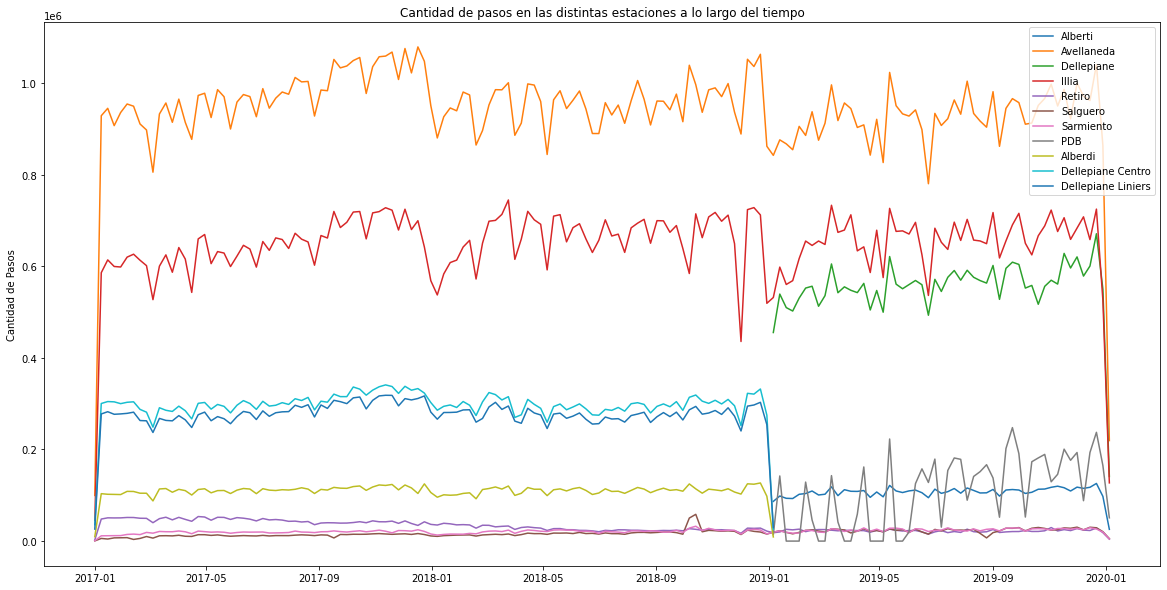

In [ ]:
#fig,ax=plt.figure()
plt.figure(figsize=(20,10))
for estacion in df.estacion.unique():
    plt.plot(df[df.estacion==estacion].resample('W', on = 'fecha').cantidad_pasos.sum(),label=estacion)
plt.legend()
plt.ylabel("Cantidad de Pasos")
plt.title("Cantidad de pasos en las distintas estaciones a lo largo del tiempo")

plt.show()

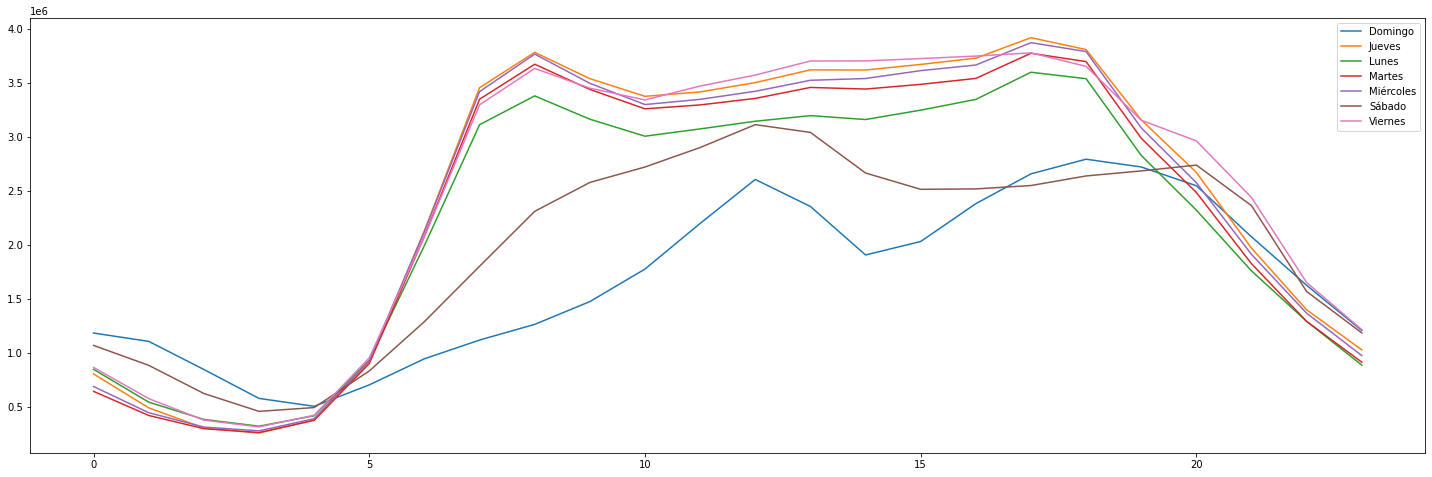

In [ ]:
dia_hora=df.groupby(["dia","hora_inicio"])["cantidad_pasos"].sum().reset_index()
dia_hora_std=df.groupby(["dia","hora_inicio"])["cantidad_pasos"].std().reset_index()

plt.figure(figsize=(25,8))
for dia in dia_hora.dia.unique():
  plt.plot(dia_hora[dia_hora.dia==dia].hora_inicio,dia_hora[dia_hora.dia==dia].cantidad_pasos,label=dia)
  #plt.fill_between(x=dia_hora[dia_hora.dia==dia].hora_inicio,y1=dia_hora[dia_hora.dia==dia].cantidad_pasos-dia_hora_std[dia_hora.dia==dia].cantidad_pasos,y2=dia_hora[dia_hora.dia==dia].cantidad_pasos+dia_hora_std[dia_hora.dia==dia].cantidad_pasos,label=dia,alpha=0.2)
plt.ylabel("Cantidad de autos")
plt.title("Cantidad de Autos por día en cada horario")
plt.xlabel("Hora del dia")
plt.legend()
plt.show()

Veremos en que sentido circulan mas a cada hora 

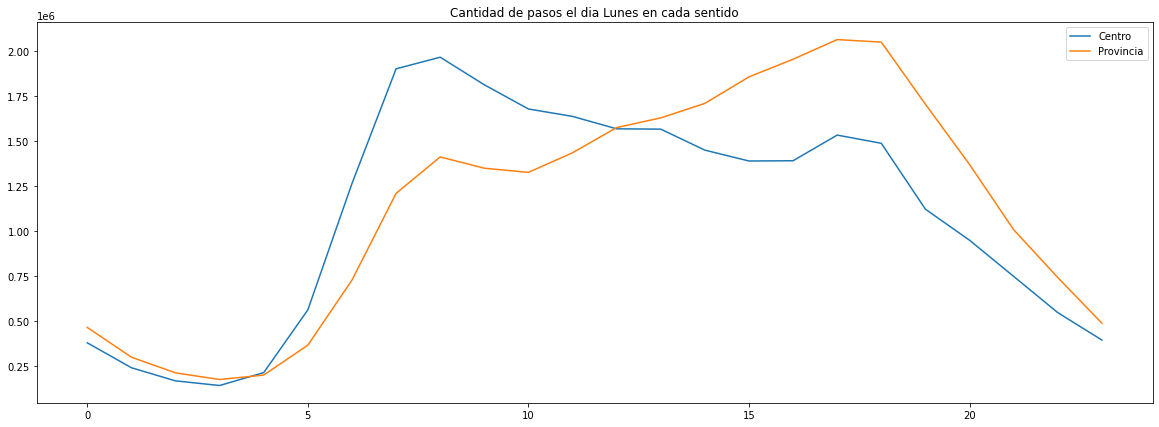

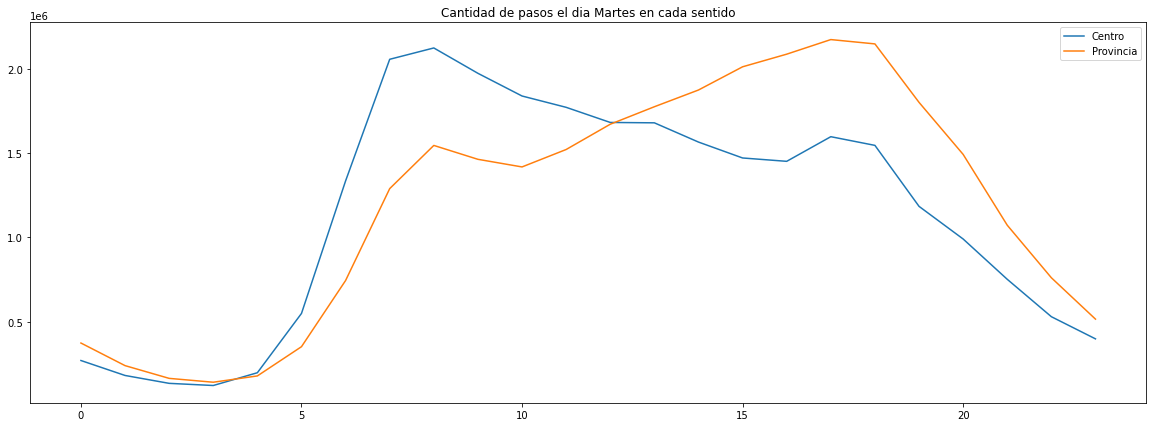

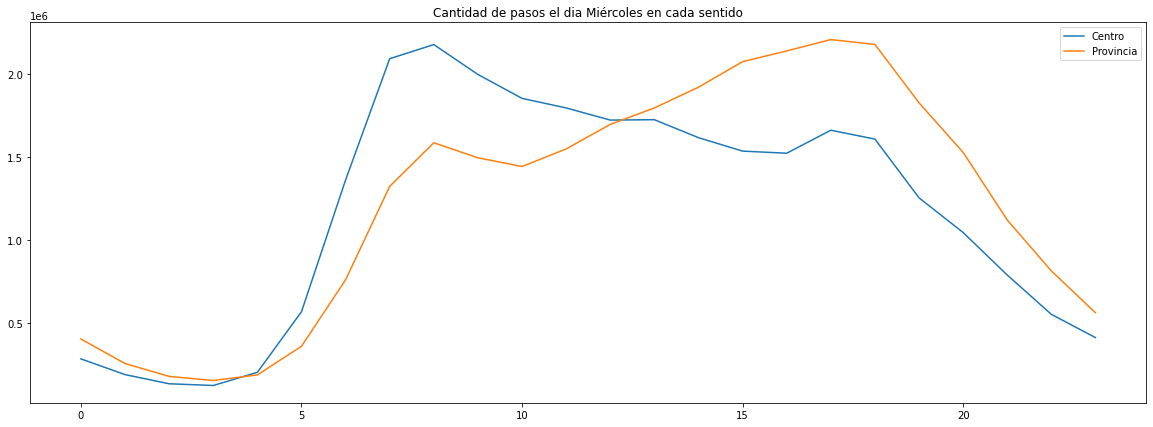

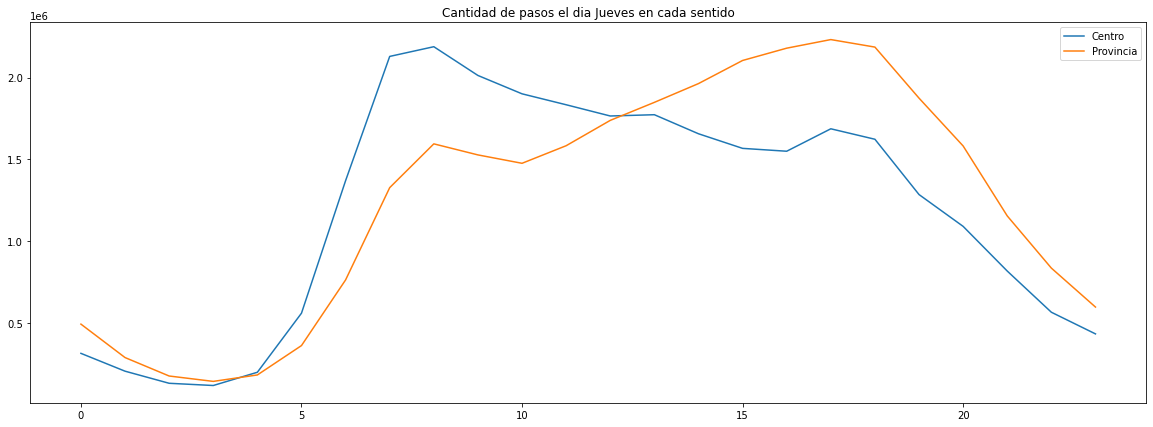

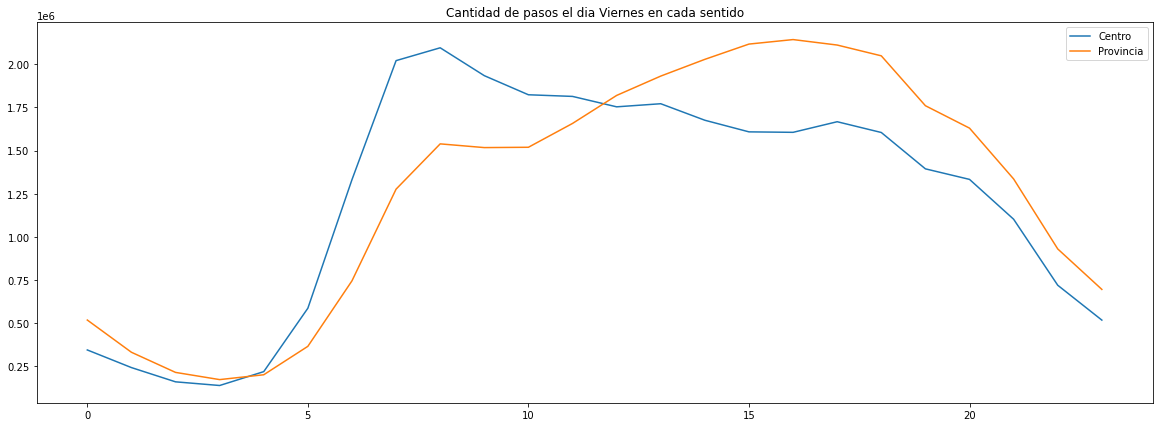

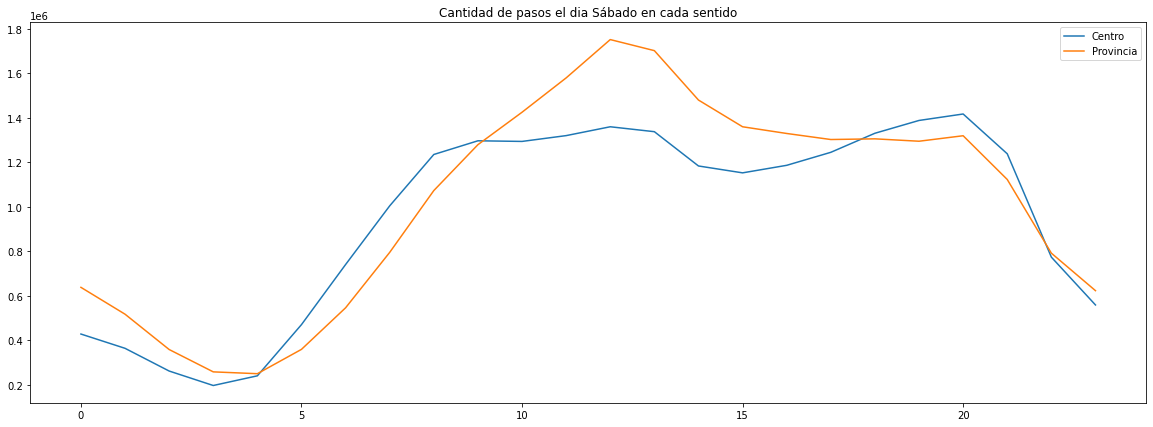

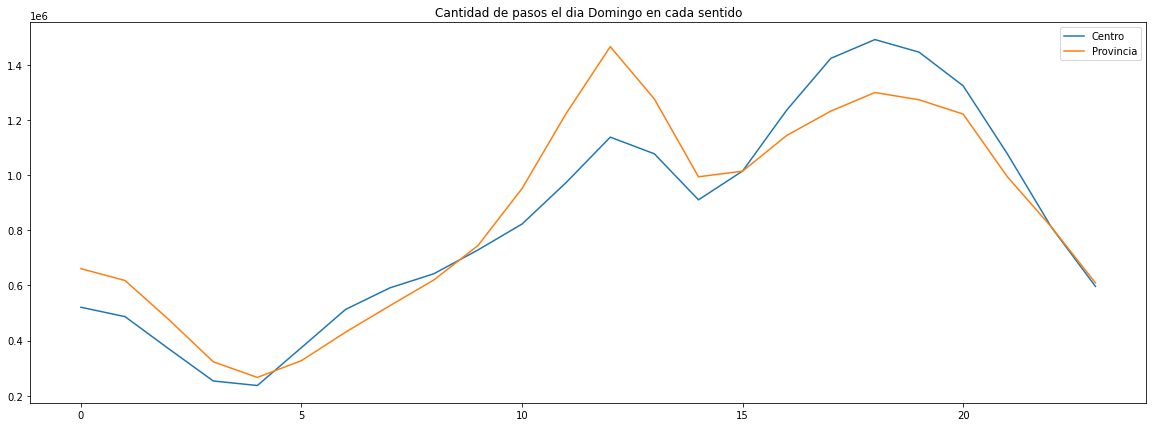

In [ ]:
dia_hora_sentido=df.groupby(["dia","hora_inicio","sentido"])["cantidad_pasos"].sum().reset_index()
dia_hora_sentido
for dia in ["Lunes","Martes","Miércoles","Jueves","Viernes","Sábado","Domingo"]:
  plt.figure(figsize=(20,7))
  plt.title(f"Cantidad de pasos el dia {dia} en cada sentido")
  plt.plot(dia_hora_sentido[np.logical_and(dia_hora_sentido.dia==dia,dia_hora_sentido.sentido=="Centro")].hora_inicio,dia_hora_sentido[np.logical_and(dia_hora_sentido.dia==dia,dia_hora_sentido.sentido=="Centro")].cantidad_pasos,label="Centro")
  plt.plot(dia_hora_sentido[np.logical_and(dia_hora_sentido.dia==dia,dia_hora_sentido.sentido=="Provincia")].hora_inicio,dia_hora_sentido[np.logical_and(dia_hora_sentido.dia==dia,dia_hora_sentido.sentido=="Provincia")].cantidad_pasos,label="Provincia")
  plt.legend()
  plt.show()

Podemos ver que mas gente va a trabajar al centro desde la provincia que de forma opuesta ya que mas temprano hay mas personas en dirección centro y leugo a la hora de la vuelta del trabajo hay más personas en direccion provincia

Mismo analisis de direccion pero por estacion

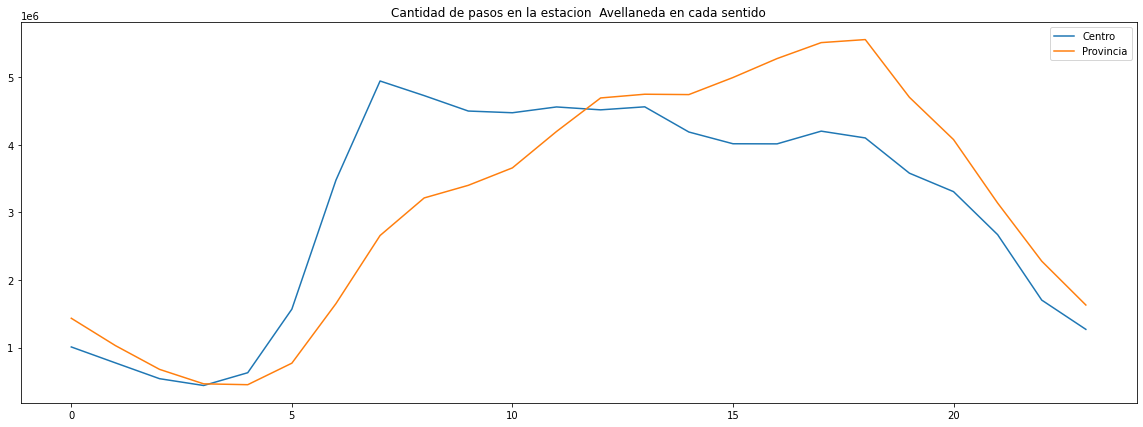

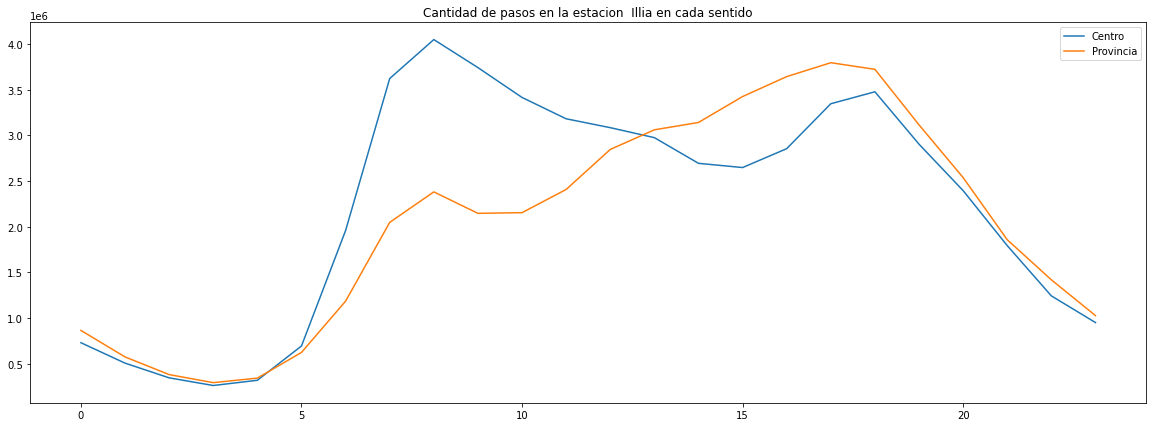

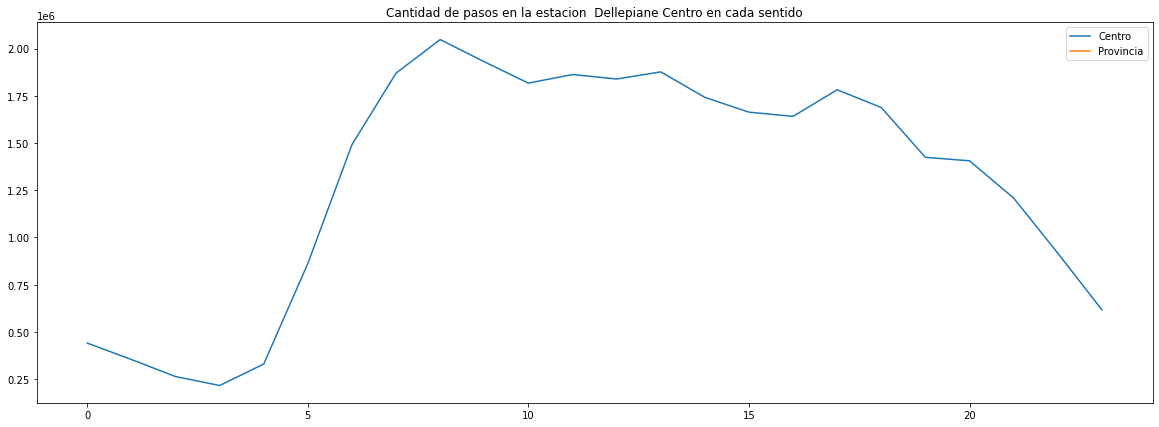

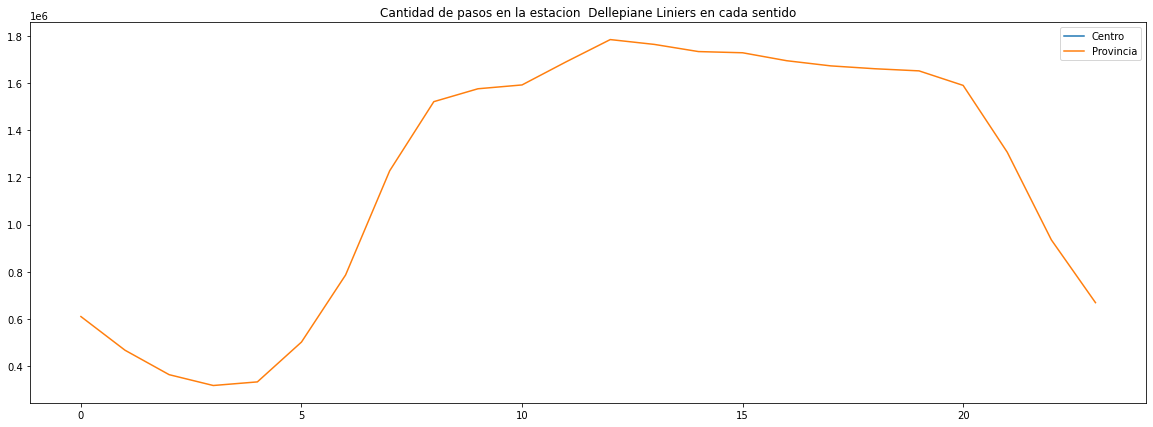

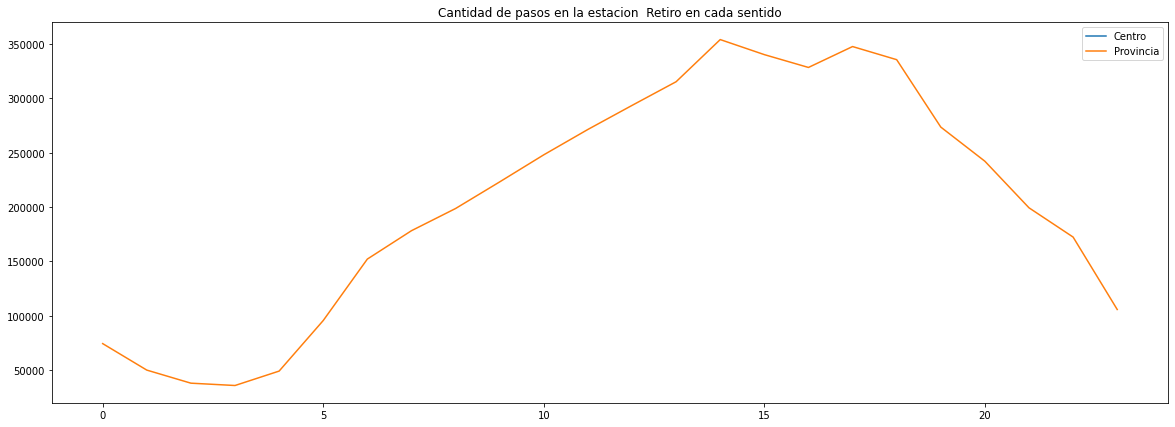

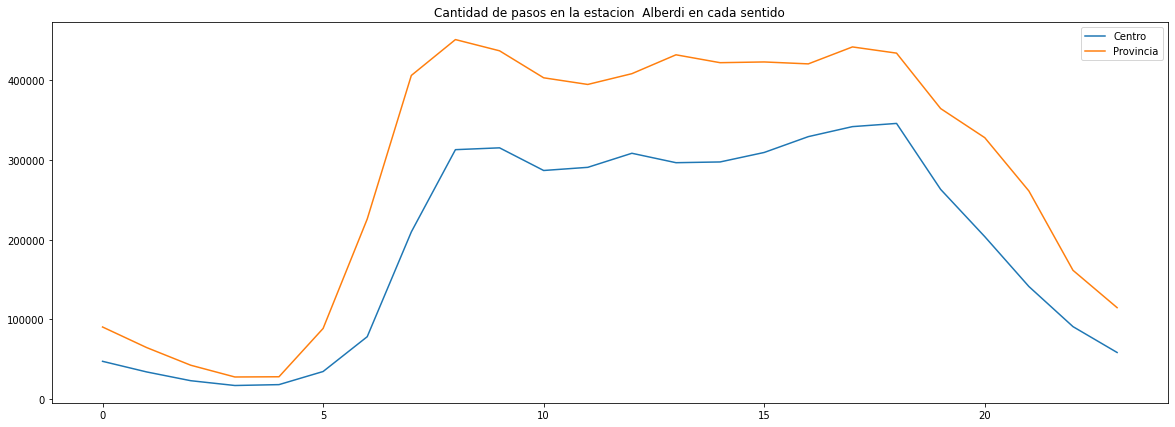

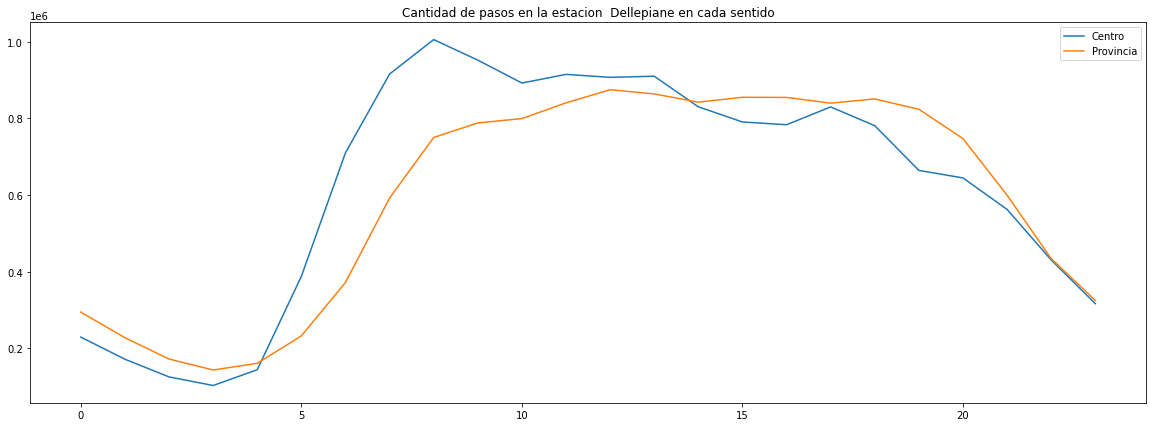

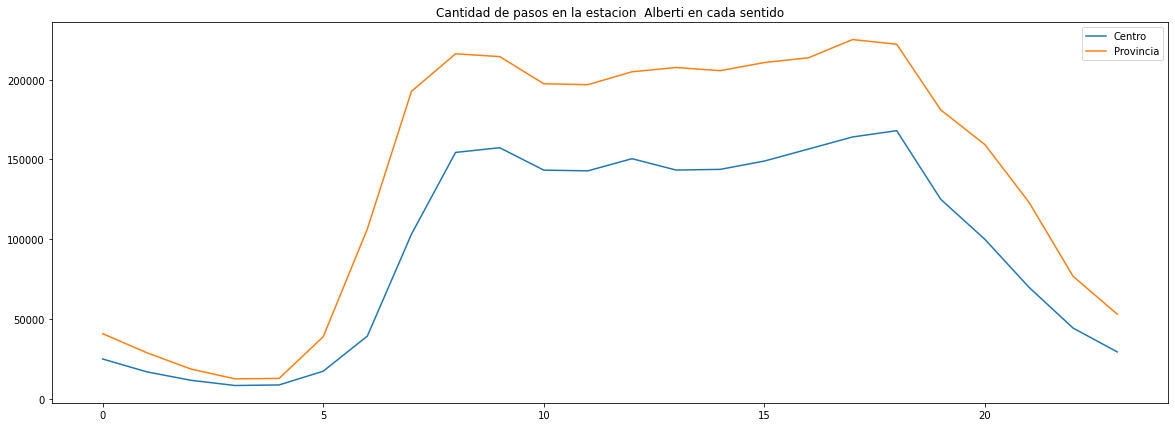

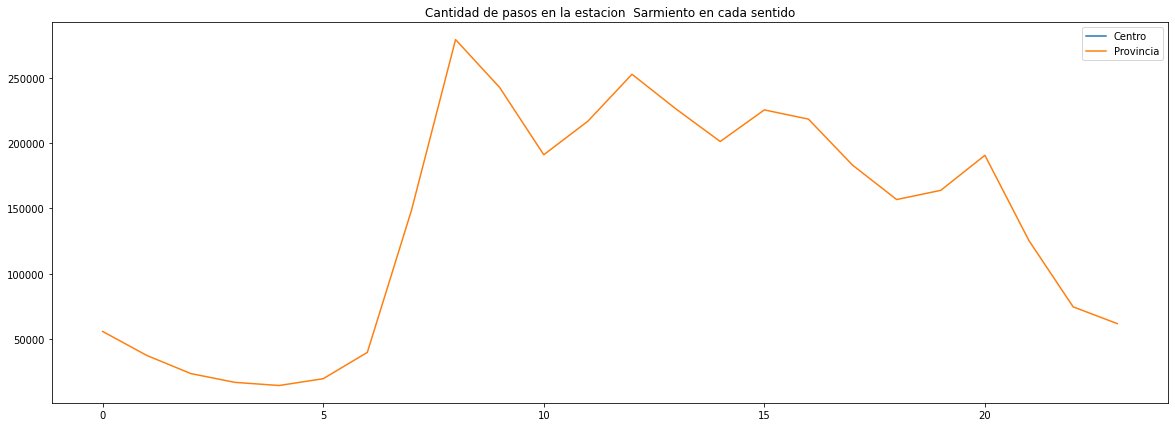

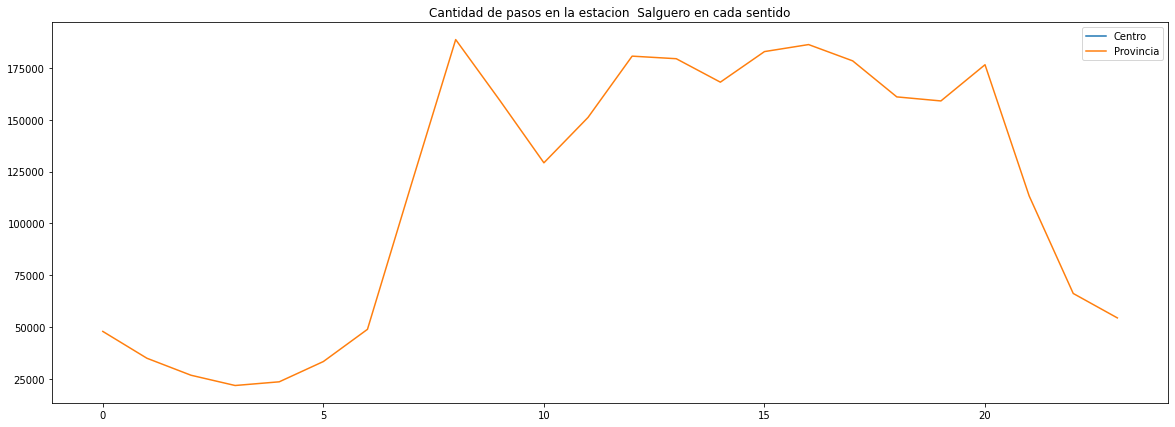

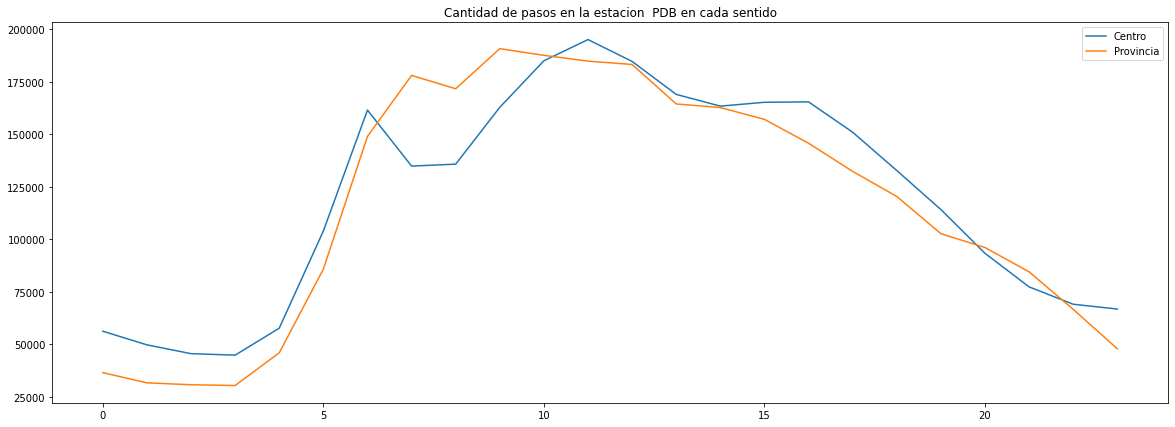

In [ ]:
estacion_hora_sentido=df.groupby(["estacion","hora_inicio","sentido"])["cantidad_pasos"].sum().reset_index()
estacion_hora_sentido
for estacion in df.estacion.value_counts().index:
  plt.figure(figsize=(20,7))
  plt.title(f"Cantidad de pasos en la estacion  {estacion} en cada sentido")
  plt.plot(estacion_hora_sentido[np.logical_and(estacion_hora_sentido.estacion==estacion,estacion_hora_sentido.sentido=="Centro")].hora_inicio,estacion_hora_sentido[np.logical_and(estacion_hora_sentido.estacion==estacion,estacion_hora_sentido.sentido=="Centro")].cantidad_pasos,label="Centro")
  plt.plot(estacion_hora_sentido[np.logical_and(estacion_hora_sentido.estacion==estacion,estacion_hora_sentido.sentido=="Provincia")].hora_inicio,estacion_hora_sentido[np.logical_and(estacion_hora_sentido.estacion==estacion,estacion_hora_sentido.sentido=="Provincia")].cantidad_pasos,label="Provincia")
  plt.legend()
  plt.show()

Que estaciones se usan mas que dias

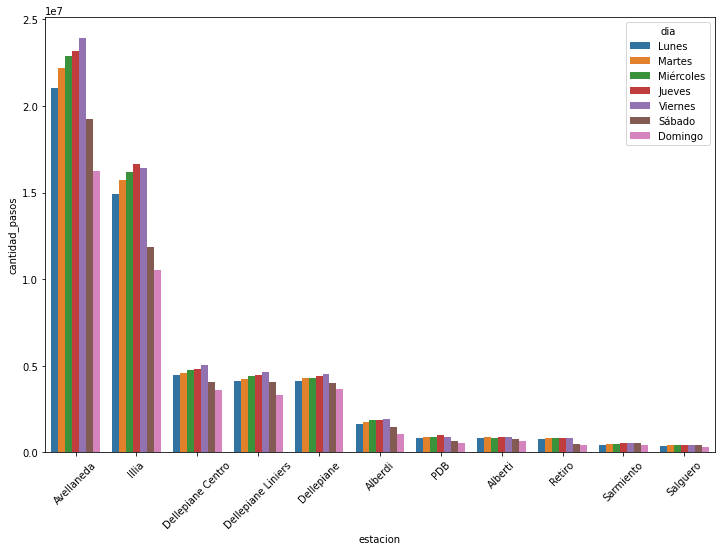

In [ ]:
dia_estacion=df.groupby(["dia","estacion"]).cantidad_pasos.sum().sort_values(ascending=False).reset_index()

plt.figure(figsize=(12,8))
sns.barplot(x=dia_estacion.estacion,y=dia_estacion.cantidad_pasos,hue=dia_estacion.dia,hue_order=["Lunes","Martes","Miércoles","Jueves","Viernes","Sábado","Domingo"])
plt.xticks(rotation=45)
plt.show()

Analisis por dias y por tipo de vehiculo

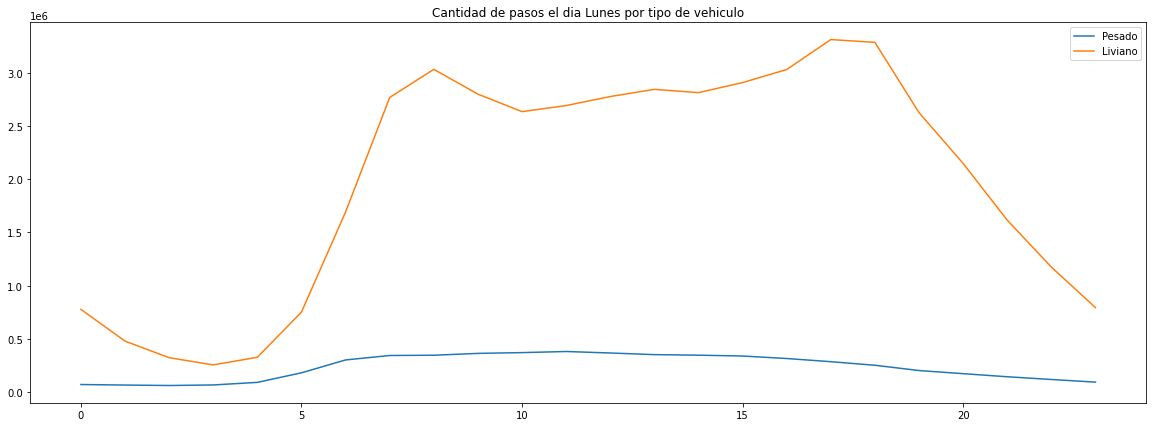

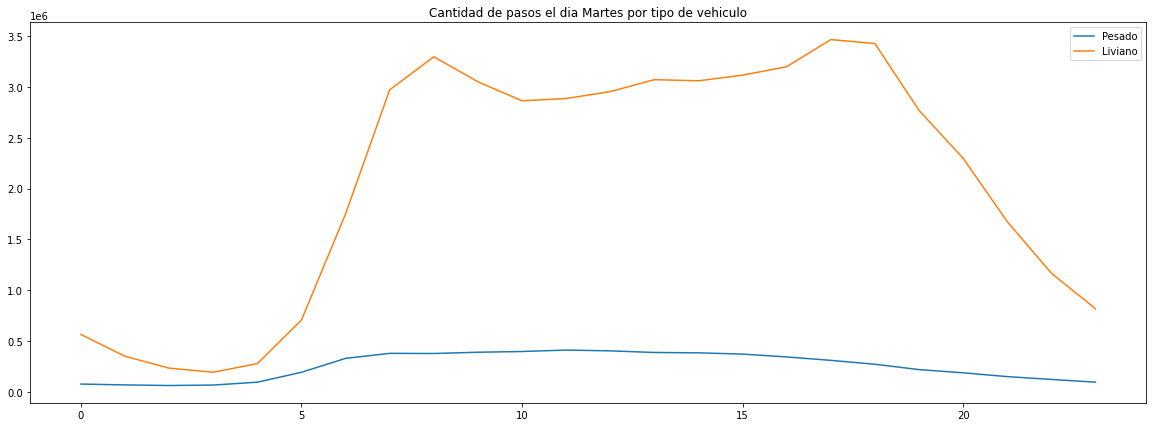

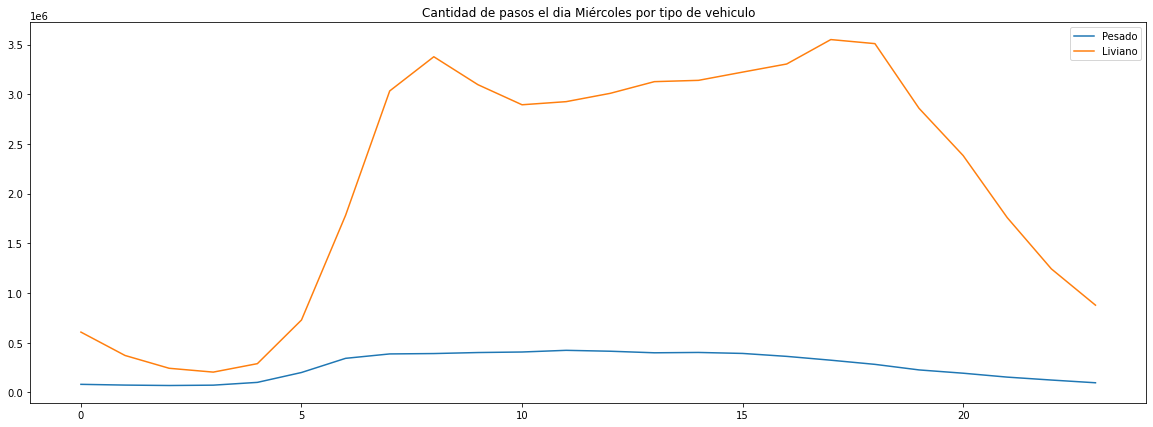

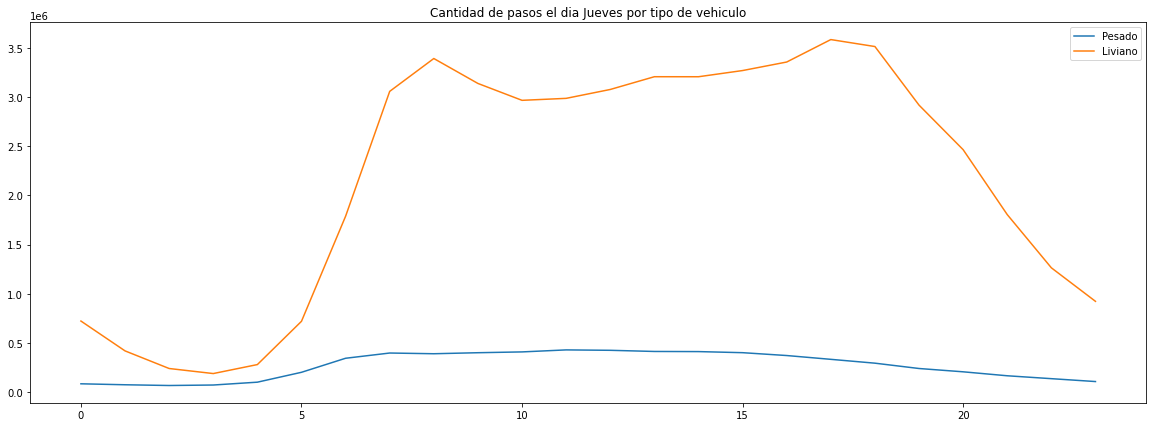

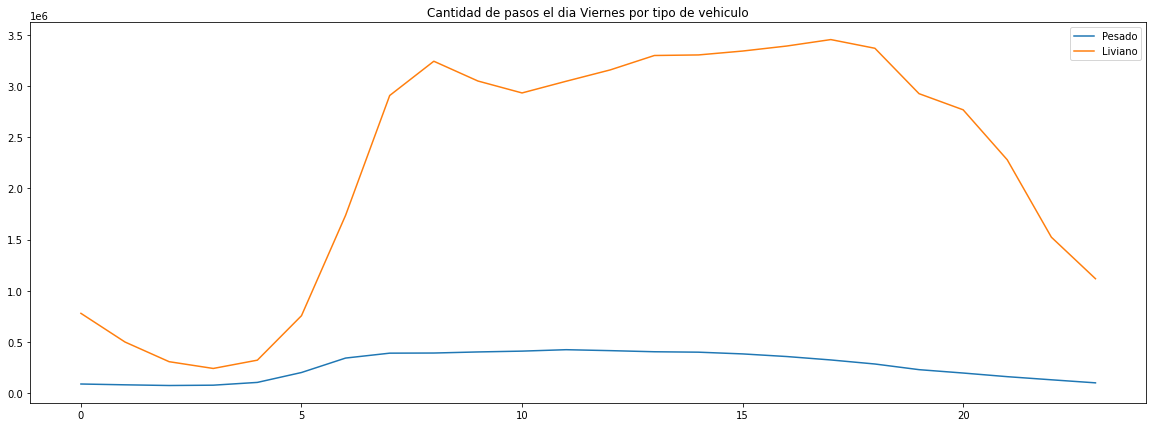

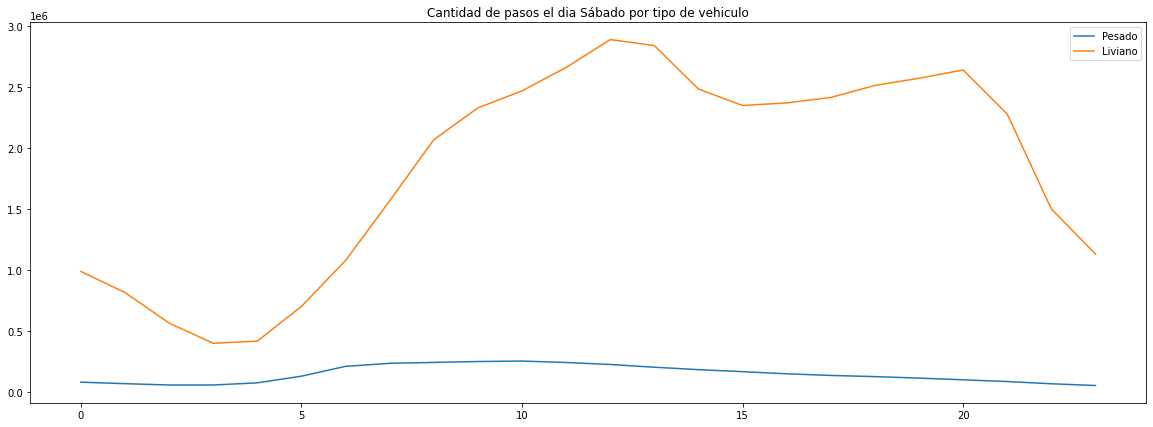

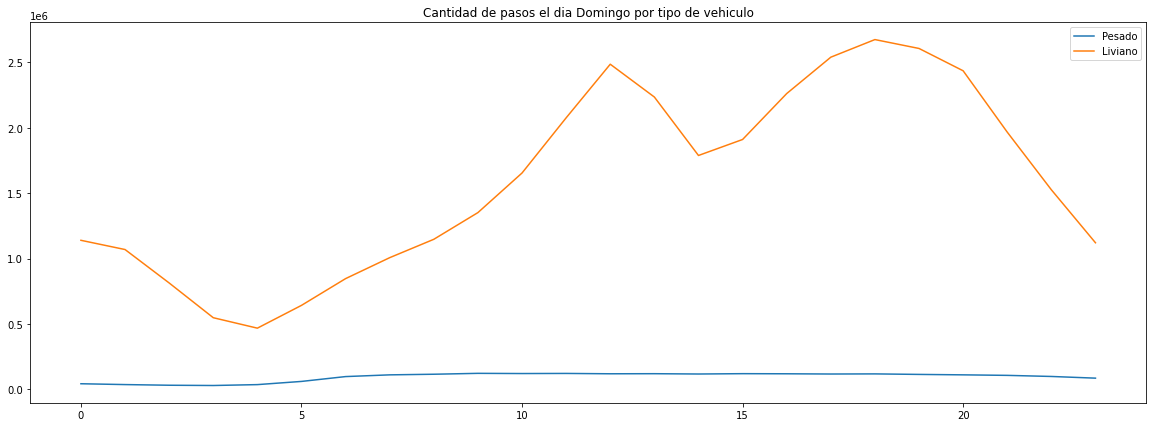

In [ ]:
df
dia_hora_vehiculo=df.groupby(["dia","hora_inicio","tipo_vehiculo"])["cantidad_pasos"].sum().reset_index()
dia_hora_vehiculo
for dia in ["Lunes","Martes","Miércoles","Jueves","Viernes","Sábado","Domingo"]:
  plt.figure(figsize=(20,7))
  plt.title(f"Cantidad de pasos el dia {dia} por tipo de vehiculo")
  plt.plot(dia_hora_vehiculo[np.logical_and(dia_hora_vehiculo.dia==dia,dia_hora_vehiculo.tipo_vehiculo=="Pesado")].hora_inicio,dia_hora_vehiculo[np.logical_and(dia_hora_vehiculo.dia==dia,dia_hora_vehiculo.tipo_vehiculo=="Pesado")].cantidad_pasos,label="Pesado")
  plt.plot(dia_hora_vehiculo[np.logical_and(dia_hora_vehiculo.dia==dia,dia_hora_vehiculo.tipo_vehiculo=="Liviano")].hora_inicio,dia_hora_vehiculo[np.logical_and(dia_hora_vehiculo.dia==dia,dia_hora_vehiculo.tipo_vehiculo=="Liviano")].cantidad_pasos,label="Liviano")
  plt.legend()
  plt.show()

### Formas de pago

por tipo de vehiculo

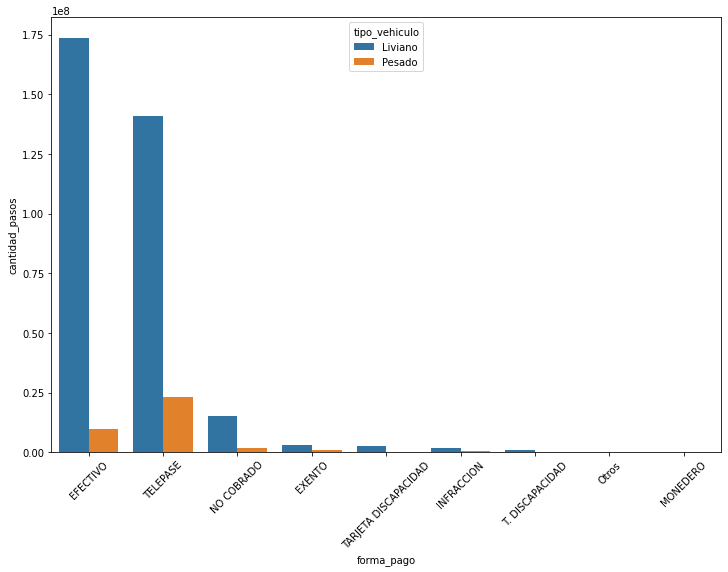

In [ ]:
vehiculo_pago=df.groupby(["tipo_vehiculo","forma_pago"]).cantidad_pasos.sum().sort_values(ascending=False).reset_index()
vehiculo_pago

plt.figure(figsize=(12,8))
sns.barplot(x=vehiculo_pago.forma_pago,y=vehiculo_pago.cantidad_pasos,hue=vehiculo_pago.tipo_vehiculo)
plt.xticks(rotation=45)
plt.show()

Tiene sentido que los vehiculos pesados utilicen mas el telepase

Intentamos hacer analisis de prophet para distintos datasets:


Primero estaciones

In [ ]:
from fbprophet import Prophet
from fbprophet.plot import plot_plotly, plot_components_plotly
plt.title("Para tener en cuenta - countplot")
sns.barplot(df.estacion.value_counts().index,df.estacion.value_counts().values)
plt.xticks(rotation=90)
plt.show()


for estacion in df.estacion.value_counts().index:
  
  m=Prophet(yearly_seasonality=True,daily_seasonality=True)

  d=df[df.estacion==estacion].resample('H', on = 'fecha').cantidad_pasos.sum().reset_index()
  d.columns=["ds","y"]

  print(f"{estacion} con {d.shape[0]/(365*24)} años registrados")
  
  m.fit(d)

  future = m.make_future_dataframe(periods=0)
  forecast = m.predict(future)

  fig2 = plot_components_plotly(m,forecast)
  
  fig2.show()
  



Output hidden; open in https://colab.research.google.com to view.

Podemos ver en la autopista illia que entre marzo y abril de 2017 no hubo circulación. Esto se puede deber a una obra en la misma. Googleando: [Construccion carril nuevo autopista Illia](http://www.construar.com.ar/2017/04/3437-adjudican-obra-para-la-nueva-autopista-illia/)

Luego formas de pago

In [ ]:
from fbprophet import Prophet
from fbprophet.plot import plot_plotly, plot_components_plotly



for forma in ['TELEPASE', 'EFECTIVO', 'EXENTO', 'INFRACCION', 'NO COBRADO',
       'TARJETA DISCAPACIDAD', 'T. DISCAPACIDAD']:
  
  m=Prophet(yearly_seasonality=True,daily_seasonality=True)

  d=df[df.forma_pago==forma].resample('H', on = 'fecha').cantidad_pasos.sum().reset_index()
  d.columns=["ds","y"]

  print(f"{forma} con {d.shape[0]/(365*24)} años registrados")
  
  m.fit(d)

  future = m.make_future_dataframe(periods=0)
  forecast = m.predict(future)

  fig2 = plot_components_plotly(m,forecast)
  
  fig2.show()
  

Output hidden; open in https://colab.research.google.com to view.

- Podemos ver una tendencia creciente en utilizar el telepase
- Una tendencia decreciente en usar el efectivo

**Analizando los datos globales:**
(Usamo promedio porque hay años que tienen datos de algunas estaciones unicamente)

In [ ]:
m=Prophet(yearly_seasonality=True,daily_seasonality=True)

d=df.resample('H', on = 'fecha').cantidad_pasos.mean().reset_index()
d.columns=["ds","y"]
  
m.fit(d)

future = m.make_future_dataframe(periods=0)
forecast = m.predict(future)

fig2 = plot_components_plotly(m,forecast)
  
fig2.show()

## Predicción


Primero para el caso de Estacion Illia y Efectivo:

In [ ]:
ts_diario = dataset.resample('D', on = 'fecha').sum()
ts_diario=ts_diario.reset_index()
ts_diario.columns=["ds","y"]
ts_diario.values

array([[Timestamp('2017-01-01 00:00:00'), 31183],
       [Timestamp('2017-01-02 00:00:00'), 51568],
       [Timestamp('2017-01-03 00:00:00'), 51093],
       ...,
       [Timestamp('2019-12-29 00:00:00'), 26259],
       [Timestamp('2019-12-30 00:00:00'), 34523],
       [Timestamp('2019-12-31 00:00:00'), 21447]], dtype=object)

Acortamos el dataset hasta el ultimo trimestre de 2019

In [ ]:
ts_diario_train=ts_diario[ts_diario.ds<datetime.datetime(2019,10,1,0,0,0)]
ts_diario_test=ts_diario[ts_diario.ds>=datetime.datetime(2019,10,1,0,0,0)]

In [ ]:
from fbprophet import Prophet
m=Prophet()
m.fit(ts_diario_train)


# Python
#holidays=
#m = Prophet(holidays=holidays)
##m.add_country_holidays(country_name='Arg')
#m.fit(df)


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [ ]:
future = m.make_future_dataframe(periods=ts_diario_test.shape[0])
forecast = m.predict(future)

# display the most critical output columns from the forecast
forecast[['ds','yhat','yhat_lower','yhat_upper']].head()
forecast[['ds','yhat','yhat_lower','yhat_upper']].shape

(1095, 4)

In [ ]:
forecast.head()
forecast.shape

(1095, 19)

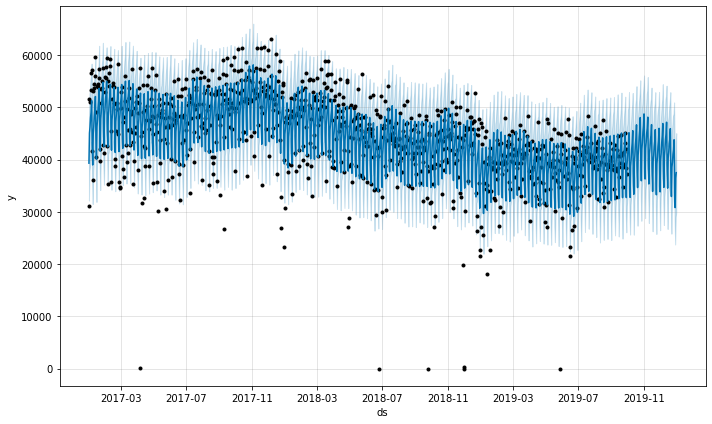

In [ ]:
# plot
fig = m.plot(forecast)

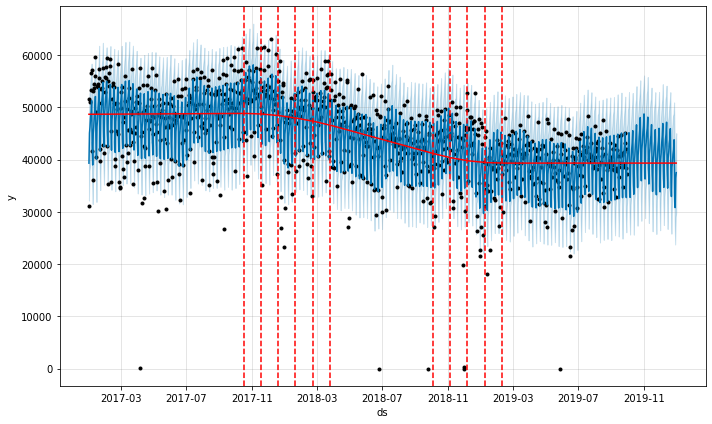

In [ ]:
from fbprophet.plot import add_changepoints_to_plot
a = add_changepoints_to_plot(fig.gca(),m,forecast)
fig

In [ ]:
forecast_pred=forecast[forecast.ds>=datetime.datetime(2019,10,1,0,0,0)][["ds","yhat"]]
ts_diario_test

ds      y
1003 2019-10-01  39669
1004 2019-10-02  34943
1005 2019-10-03  35054
1006 2019-10-04  43775
1007 2019-10-05  45150
...         ...    ...
1090 2019-12-27  40182
1091 2019-12-28  30681
1092 2019-12-29  26259
1093 2019-12-30  34523
1094 2019-12-31  21447

[92 rows x 2 columns]

In [ ]:
from sklearn.metrics import mean_squared_error
rmse=np.sqrt(mean_squared_error(ts_diario_test.y,forecast_pred.yhat))
print(f"RMSE= {rmse}")
print(f"RMSE/average of test data= {rmse/ts_diario_test.y.mean()}" )

RMSE= 5837.9113176964975
RMSE/average of test data= 0.15284873729117723


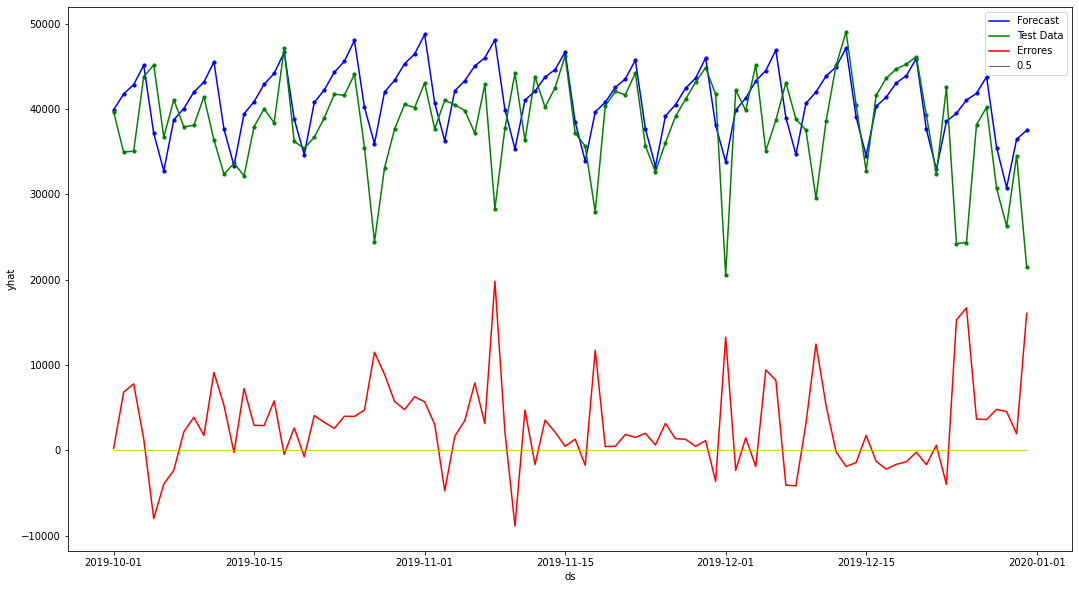

In [ ]:
plt.figure(figsize=[18,10])
plt.scatter(x=forecast_pred.ds,y=forecast_pred.yhat,c="b",s=10)
sns.lineplot(x=forecast_pred.ds,y=forecast_pred.yhat,color="b",label="Forecast")


plt.scatter(x=ts_diario_test.ds,y=ts_diario_test.y,c="g",s=10)
sns.lineplot(x=ts_diario_test.ds,y=ts_diario_test.y,color="g",label="Test Data")

sns.lineplot(x=ts_diario_test.ds,y=forecast_pred.yhat-ts_diario_test.y,color="r",label="Errores")

sns.lineplot(x=ts_diario_test.ds,y=0,color="y",size=0.5)
plt.show()

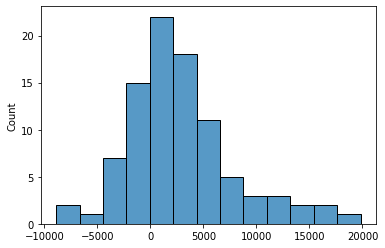

In [ ]:
sns.histplot(forecast_pred.yhat-ts_diario_test.y)

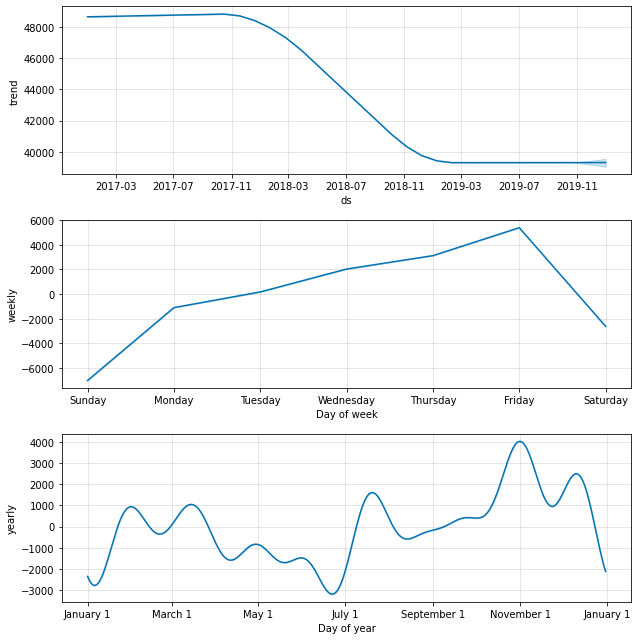

In [ ]:
fig2 = m.plot_components(forecast)

In [ ]:
from fbprophet.plot import plot_plotly, plot_components_plotly
plot_plotly(m, forecast)


## Predecimos para la última quincena de 2019

In [ ]:
data=df[np.logical_and(df["estacion"]=="Illia",df["forma_pago"]=="EFECTIVO")].resample("D",on="fecha")[["cantidad_pasos"]].sum().reset_index()
data.columns=["ds","y"]

Acortamos el dataset hasta la ultima quincena de 2019

In [ ]:
data_train=data[data.ds<datetime.datetime(2019,12,15,0,0,0)]
data_test=data[data.ds>=datetime.datetime(2019,12,15,0,0,0)]

In [ ]:
from fbprophet import Prophet
m=Prophet()
m.fit(data_train)


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [ ]:
future = m.make_future_dataframe(periods=data_test.shape[0])
forecast = m.predict(future)

# display the most critical output columns from the forecast
forecast[['ds','yhat','yhat_lower','yhat_upper']].head()
forecast[['ds','yhat','yhat_lower','yhat_upper']].shape

(1095, 4)

In [ ]:
forecast_pred=forecast[forecast.ds>=datetime.datetime(2019,12,15,0,0,0)][["ds","yhat"]]

In [ ]:
from sklearn.metrics import mean_squared_error
rmse=np.sqrt(mean_squared_error(data_test.y,forecast_pred.yhat))
print(f"RMSE= {rmse}")
print(f"RMSE/average of test data= {rmse/data_test.y.mean()}" )

RMSE= 6591.736490862415
RMSE/average of test data= 0.18430387464891665


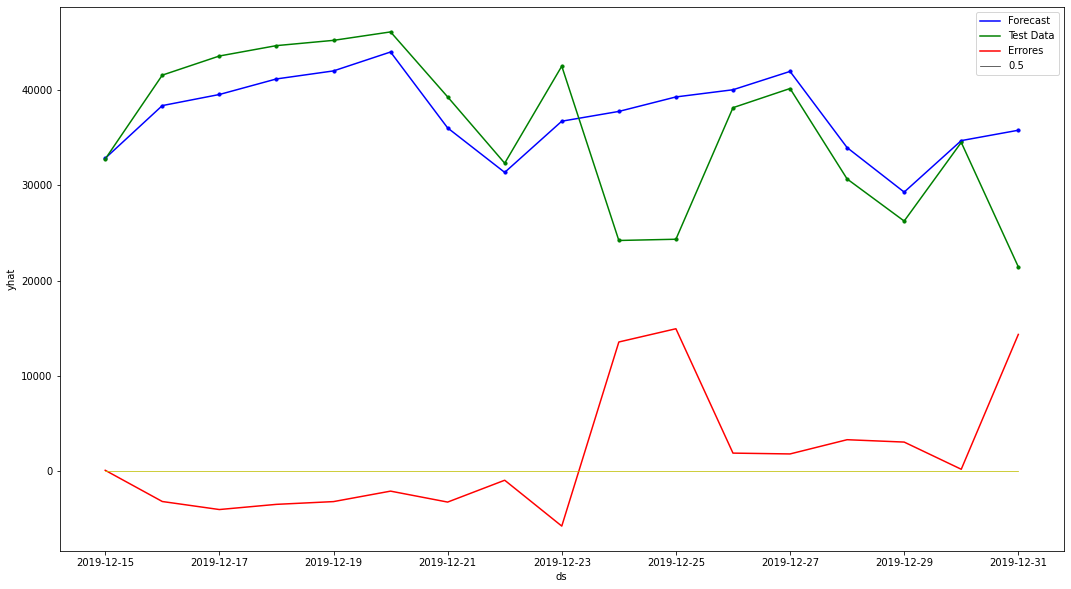

In [ ]:
plt.figure(figsize=[18,10])
plt.scatter(x=forecast_pred.ds,y=forecast_pred.yhat,c="b",s=10)
sns.lineplot(x=forecast_pred.ds,y=forecast_pred.yhat,color="b",label="Forecast")


plt.scatter(x=data_test.ds,y=data_test.y,c="g",s=10)
sns.lineplot(x=data_test.ds,y=data_test.y,color="g",label="Test Data")

sns.lineplot(x=data_test.ds,y=forecast_pred.yhat-data_test.y,color="r",label="Errores")

sns.lineplot(x=data_test.ds,y=0,color="y",size=0.5)
plt.show()